In [1]:
#from pyinstrument import Profiler

# Import the dependencies
import sys
import pandas as pd
import numpy as np
from numpy.random import default_rng
import time
import numba
from numba.typed import List
from joblib import Parallel, delayed

from sklearn.datasets import make_classification
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import HDBSCAN
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score

from matplotlib import pyplot as plt

## Create a test dataset

In [2]:
# ## Create a test dataset
X, y = make_classification(n_samples=1000, n_features=100, n_informative=11, n_redundant=87, n_repeated=2, n_classes=5, n_clusters_per_class=1, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=42) 

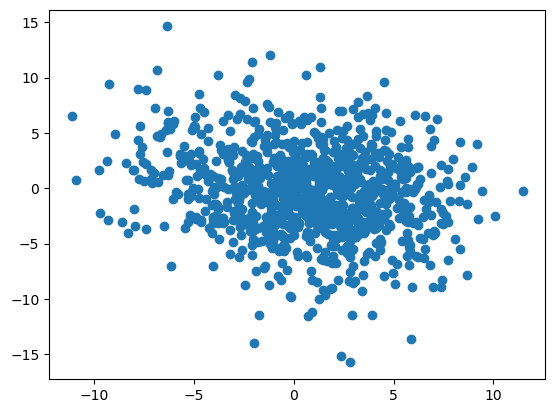

In [3]:
plt.scatter(X[:,0], X[:,1])
plt.show()

In [4]:
test_df = pd.DataFrame(X)
test_df = test_df.add_prefix('feature_')
test_df

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99
0,3.311782,-0.529963,-6.169316,-0.877293,-1.862626,1.313516,4.006420,-5.634504,0.276854,5.090710,...,-1.616570,-2.826764,1.876726,-1.810241,-3.327932,-5.596835,1.430061,-1.434919,-2.509839,-0.983358
1,-3.231006,2.360626,1.462062,-1.991379,-4.215958,1.735843,-8.380509,5.483691,4.658360,9.425324,...,3.592989,2.161182,7.032639,-1.973171,-0.012907,-8.516022,1.171842,5.915389,-4.584808,1.897530
2,0.064531,2.344843,3.545589,2.104399,-0.590796,-0.275862,-2.632464,-3.003645,0.406711,-4.233015,...,7.291110,3.869360,1.911807,-6.261476,-1.300948,-0.245126,2.056668,-3.888145,-4.425887,-2.754083
3,3.224498,1.766124,0.551554,-3.091685,1.261745,-4.876566,-2.086298,-2.898057,5.175963,0.556392,...,-0.892743,4.545308,-2.061285,-8.128642,-2.814404,-3.434227,2.746046,-0.864593,-2.346940,1.353095
4,4.288778,-1.325469,-2.748100,-4.688589,1.260586,-3.061599,4.365045,-3.921870,3.380462,-4.873868,...,-4.589644,-0.227847,-2.889456,-3.425103,-1.828547,-2.708246,-0.377181,-3.912811,-0.084614,0.040769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.618747,-0.098265,3.589567,2.820741,1.194101,-3.587255,-5.314121,1.558472,-1.315257,5.350805,...,9.322122,4.407764,-2.913207,-4.487179,0.461692,-3.962805,0.112247,1.804651,2.082184,-4.076680
996,2.025491,0.715190,0.684810,0.401431,2.068284,-2.934137,-3.241308,-0.710514,0.961026,-0.455988,...,2.284452,4.698502,-2.865954,-1.662922,1.048983,-1.774975,0.729762,-0.844783,1.234384,-2.077394
997,7.743301,1.778473,-2.846105,-0.433585,-0.415567,-0.377135,4.508521,-6.037286,-2.458136,3.139495,...,-1.558045,2.177363,-1.406219,-0.927904,-1.505962,-9.256984,3.026449,1.514339,3.692485,2.427929
998,1.351416,4.641703,-0.688014,-1.446886,2.937858,-3.412283,-2.272426,1.729373,0.135800,1.579727,...,0.284795,3.565456,-8.536618,-3.760788,0.747339,-1.947217,1.186213,-0.208328,3.979306,-3.427967


In [5]:
# Convert the dataframe to a Numpy array for enhanced performance
test_np = test_df.to_numpy()

## Principal Feature Analysis ##

#### Define functions to select dataset features that provide relevant information for clustering. 
##### Only important features are used to compute clusters from the complete (non-pca) dataset.

In [6]:
# =============================================================================
# Helper function - Custom Mean processing to override limitations of Numba compatibility with Numpy features
@numba.jit(nopython=True)
def custom_mean(arr):
    if arr.ndim == 1:
        return arr.mean()
    elif arr.ndim == 2:
        # For 2D arrays, manually compute the mean of each column.
        means = np.zeros(arr.shape[1])
        for i in range(arr.shape[1]):
            means[i] = arr[:, i].mean()
        return means
    else:
        raise ValueError("Invalid array dimensions for custom_mean")

In [7]:
# =============================================================================
# Helper function - Calinski Harbasz Score Calculation
def calculate_calinski_harbasz(np_array, labels):
    if len(np.unique(labels)) > 1:
        c_h = calinski_harabasz_score(np_array, labels)
        calinski_harbasz = log_scale_value(c_h)
        #print(f'    calinski_harbasz index = {calinski_harbasz}')
        return calinski_harbasz
    else:
        return 0

In [8]:
# =============================================================================
# Helper function - Davies-Bouldin Score Calculation
def calculate_davies_bouldin(np_array, labels):
    if len(np.unique(labels)) > 1:
        davies_bouldin = davies_bouldin_score(np_array, labels)
        #print(f'   davies_bouldin score = {davies_bouldin}')
        return davies_bouldin
    else:
        return 0

In [9]:
# =============================================================================
# Helper function - Silhouette Coefficient Calculation
def calculate_silhouette(np_array, labels):
    if len(np.unique(labels)) > 1:
        silhouette_val = silhouette_score(np_array, labels)
        #print(f' Silhouette Score = {silhouette_val}')
        return silhouette_val
    else:
        return 0

In [10]:
# =============================================================================
# Helper function - Scatter Separability Calculation
def calculate_scatter_separability(np_array, labels):
    """
    Calculates the Scatter Separability (SSC) between clusters in a NumPy array.

    Args:
        np_array: The NumPy array containing the data points.
        labels: The cluster labels for each data point.

    Returns:
        The Scatter Separability score (SSC).
    """
    unique_labels = np.unique(labels)
    n_features = np_array.shape[1]
    overall_mean = custom_mean(np_array)

    S_w = np.zeros((n_features, n_features))
    S_b = np.zeros((n_features, n_features))

    for label in unique_labels:
        X_k = np_array[labels == label]
        mean_k = custom_mean(X_k)
        if mean_k.ndim == 1:
            mean_k = mean_k[:, None]  # Ensure mean_k is a column vector
        n_k = X_k.shape[0]  # Number of samples in current class
        mean_diff = mean_k - overall_mean[:, None]  # Ensure mean_diff is correctly shaped
    
        S_w_k = np.cov(X_k, rowvar=False, bias=True) * (n_k - 1)  # Compute within-class scatter for class k
        S_w += S_w_k
    
        mean_diff = mean_diff.reshape(-1, 1)  # Reshape mean_diff as column vector if not already
        S_b += n_k * np.dot(mean_diff, mean_diff.T)  # Correct outer product computation

    # Handle singular S_w by adding a small identity matrix to ensure invertibility
    if np.linalg.cond(S_w) > 1e10:
        S_w += np.eye(S_w.shape[0]) * 1e-4

    ssc = np.trace(np.linalg.inv(S_w).dot(S_b))
    final_ssc = log_scale_value(ssc)
    #print(f'+ computed SSC - value = {final_ssc} ')
    return final_ssc

In [11]:
# =============================================================================
# Helper function - Performs Logarithmic scaling of cluster quality score metrics that have unbounded positive ranges - Numba acceleration
@numba.jit(nopython=True)
def log_scale_value(value, offset=1):
    """
    Applies a logarithmic scaling to a value.
    
    Parameters:
    - value: The positive metric value to be scaled.
    - offset: A small positive value to avoid log(0) when the metric is zero.
    - scale_max: An upper limit to scale the logarithmic value to, for normalization.
    
    Returns:
    - scaled_value: The logarithmically scaled value, normalized to the range [0, scale_max].
    """
    # Apply logarithmic scaling
    log_scaled_value = np.log(value + offset)
    
    # TBD, normalize the log-scaled value to a specific range, e.g., [0, scale_max]
    # if/when implemented, add ", scale_max=1000" as a function parameter
    
    return log_scaled_value


In [12]:
# =============================================================================
# Helper function - Normalization of criterion values to remove bias due to number of clusters - Numba acceleration
@numba.jit(nopython=True)
def cross_projection_normalization(clustering_medoids, scatter_criteria_score, silhouette_criteria_score, davies_bouldin_score, calinski_harbasz_index):
    n_clusters = len(clustering_medoids)
    projections = np.zeros((n_clusters, n_clusters))

    for j in range(n_clusters):
        for k in range(j + 1, n_clusters):
            medoid_j = clustering_medoids[j]
            medoid_k = clustering_medoids[k]
            distance = np.linalg.norm(medoid_j - medoid_k)
            projections[j][k] = distance
            projections[k][j] = distance

   # Check if all distances are zero
    if np.all(projections == 0):
        #print("CNP - All pairwise distances are zero! Cannot compute Normalized Score.")
        return 0 
    
    # Flatten the array and filter non-zero distances
    flat_projections = projections.ravel()
    non_zero_projections = flat_projections[flat_projections > 0]
    
    if non_zero_projections.size == 0:
        #print("CNP - non_zero_projections is empty. Cannot compute Normalized Score.")
        return 0

    # Calculate mean of non-zero distances
    mean_projection = np.mean(non_zero_projections)

    # Normalizing the criteria scores with the mean of projections
    # Adjusting the formula to consider Davies-Bouldin Score. Recall: For Davies-Bouldin, lower is better.
    # We add 1 to both the numerator and denominator to ensure it doesn't lead to division by zero or negative values.

    # Combined normalization factor incorporates all metrics.
    normalization_denominator = (1 + mean_projection + davies_bouldin_score) 
    normalization_numerator = (1 + scatter_criteria_score + silhouette_criteria_score + calinski_harbasz_index)
    normalized_score = normalization_numerator / normalization_denominator

    return normalized_score

In [13]:
# =============================================================================
# Primary function - calls functions to generate cluster metrics in parallel
def score_subset_clusters(subset_array, np_array, cluster_labels, clustering_medoids):
    # Define tasks to be executed in parallel
    tasks = [delayed(calculate_scatter_separability)(subset_array, cluster_labels),
             delayed(calculate_silhouette)(subset_array, cluster_labels),
             delayed(calculate_davies_bouldin)(subset_array, cluster_labels),
             delayed(calculate_calinski_harbasz)(subset_array, cluster_labels)]
    
    # Execute tasks in parallel and unpack results
    scatter_separability, silhouette_score, davies_bouldin_score, calinski_harbasz_index = Parallel(n_jobs=4)(tasks)
    
    # Pass the results to the normalization function
    normalized_score = cross_projection_normalization(clustering_medoids, scatter_separability, silhouette_score, davies_bouldin_score, calinski_harbasz_index)

    return normalized_score

In [14]:
# =============================================================================
# Primary function - Initializes the clustering algorithm
def initialize_clustering_instance(clustering_algorithm, rng, flag):
    if flag == 'reverse': # Use vanilla algoritms for reverse-search feature scoring to ensure a consistent comparison
        if clustering_algorithm == 'kmedoids':
            return KMedoids(n_clusters=2, init='k-medoids++'), 0, 'na', 0, 0
        elif clustering_algorithm == 'hdbscan':
            return HDBSCAN(store_centers="medoid", n_jobs=-1), 0, 'na', 0, 0
    else:
        metrics = ['manhattan', 'euclidean', 'chebyshev', 'canberra', 'hamming']  # Available metrics - pick one
        if clustering_algorithm == 'kmedoids':
            #metrics = ['manhattan', 'euclidean', 'cosine']  # Available metrics - pick one
            k_val = rng.integers(2, 10)
            metric = rng.choice(metrics)  # Randomly select a metric
            return KMedoids(n_clusters=k_val, init='k-medoids++', metric=metric), k_val, metric, 0, 0
        elif clustering_algorithm == 'hdbscan':
            min_cluster_size = rng.choice([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150])
            min_samples = min_cluster_size + rng.choice([10, 20, 30, 40, 50, 60, 70]) # Higher values force conservative clustering
            metric = rng.choice(metrics)  # Randomly select a metric
            return HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, metric=metric, cluster_selection_method='eom', store_centers="medoid", n_jobs=-1), 0, metric, min_cluster_size, min_samples
        else:
            raise ValueError("Unsupported clustering algorithm")

In [15]:
# =============================================================================
# Primary function - Evaluates the subset_array
def evaluate_subset(clustering_algorithm, subset_array, np_array, rng, flag):
    clustering_instance, k_val, metric, min_cluster_size, min_samples = initialize_clustering_instance(clustering_algorithm, rng, flag)
    current_labels = clustering_instance.fit_predict(subset_array)
    clustering_medoids = getattr(clustering_instance, 'cluster_centers_', getattr(clustering_instance, 'medoids_', None))
    return score_subset_clusters(subset_array, np_array, current_labels, clustering_medoids), k_val, metric, min_cluster_size, min_samples

In [16]:
# =============================================================================
# Primary function - Creates a starter_set from the available_indices
def select_starter_set(available_indices, interim_features, starter_set_size, rng):
    remaining_indices = list(available_indices - interim_features)
    if len(remaining_indices) <= starter_set_size: # Check if there are enough indices to create a full starter_set
        return rng.choice(remaining_indices, len(remaining_indices), replace=False), 0
    else:
        return rng.choice(remaining_indices, starter_set_size, replace=False), 1

In [17]:
# =============================================================================
# Primary function - Adds a new score and the clustering parameters to the collection
def update_best_scores(best_scores, score, feature, k_val, metric, cluster_size, num_samples, interim_features, available_indices):
    best_scores['k_val'].append(k_val) # K-Medoids - Track the target k
    best_scores['cluster_size'].append(cluster_size) # HDBSCAN - Track the size of the clusters
    best_scores['num_samples'].append(num_samples)  # HDBSCAN - Track the number of samples per cluster
    best_scores['metric'].append(metric)  # K-Medoids - Track the metric
    interim_features.add(feature)
    available_indices.remove(feature)
    return available_indices, interim_features, best_scores

In [18]:
# =============================================================================
# Primary function - Score the interim_features as they are removed - determine whether any ore not needed.
def evaluate_feature_removal(np_array, clustering_algorithm, current_features, feature_to_remove, rng, flag):
    # Remove the specified feature from the current feature set
    modified_features = [f for f in current_features if f != feature_to_remove]
    
    # Subset the np_array to include only the modified feature set
    subset_array = np_array[:, modified_features]
    
    # Evaluate the clustering with the modified feature set
    score, _, _, _, _, = evaluate_subset(clustering_algorithm, subset_array, np_array, rng, flag)
    
    return score

In [19]:
# =============================================================================
# Primary function - Evaluate the scored interim_features - remove unneeded if below criteria.
def perform_reverse_search(np_array, clustering_algorithm, interim_features, global_best_score, rng):
    refined_features = set(interim_features)
    features_removed = True  # Flag to track if any features were removed in the last pass
    local_best_score = global_best_score  # Initialize local best score with global best score

    while features_removed:
        features_removed = False  # Reset the flag for the current pass
        if len(refined_features) == 2:
            print('Need to collect more candidate features - we only have 2 features left.')
            return refined_features, local_best_score
        else:
            subset_array = np_array[:, list(refined_features)]
            baseline_score, _, _, _, _, = evaluate_subset(clustering_algorithm, subset_array, np_array, rng, 'reverse')  # score the collected features before testing feature removal
            print(f'Combined set baseline Score = {baseline_score:.4f}')
            test_scores = []  # Store feature removal scores for comparison

            # Evaluate feature removal in parallel
            test_scores = Parallel(n_jobs=8)(
                delayed(evaluate_feature_removal)(np_array, clustering_algorithm, list(refined_features), feature, rng, 'reverse')
                for feature in refined_features
            )
            test_scores = list(zip(refined_features, test_scores))  # Combine feature indices with their scores

            candidate_removal, candidate_score = max(test_scores, key=lambda x: x[1])  # Use the key argument of the max() function to specify that we want to find the maximum based on the second element of each tuple in test_scores

            print(f'Candidate Removal feature {candidate_removal} generated the top score {candidate_score:.4f} when removed from the refined_feature set.')
            print(f'Current best score is {local_best_score}')
            if candidate_score > local_best_score:  # The score improves with the feature removed and is better than the local best score
                refined_features.remove(candidate_removal)
                features_removed = True  # Indicate that a feature was removed in this pass
                local_best_score = candidate_score  # Update the local best score
                print(f'Baseline Score improved by removing feature {candidate_removal}. New baseline score is {local_best_score:.4f}')

    return refined_features, local_best_score


In [20]:
# =============================================================================
# Primary function - Evaluates new features alongside the initial collection of important features
def evaluate_combinations(np_array, clustering_algorithm, available_indices, refined_features, rng, best_scores, global_best_score):
    best_combination_score = global_best_score  # Use the global best score as the starting point

    for _ in range(70):  # Number of iterations to refine the feature set
        updated = False

        # Create a list of features to evaluate
        features_to_evaluate = list(available_indices - refined_features)

        # Evaluate combination and features in parallel
        evaluation_results = Parallel(n_jobs=8)(
            delayed(evaluate_subset)(clustering_algorithm, np_array[:, list(refined_features) + [feature]], np_array, rng, 'na')
            for feature in features_to_evaluate
        )

        for idx, (normalized_score, k_val, metric, cluster_size, num_samples) in enumerate(evaluation_results):
            feature = features_to_evaluate[idx]

            # Update best combination if necessary
            if normalized_score > best_combination_score:
                updated = True
                best_combination_score = normalized_score
                best_feature = feature
                best_clust = cluster_size
                best_num_samps = num_samples
                best_k = k_val
                best_metric = metric

        # If a better combination was found, add its feature to refined_features
        if updated:
            updated = False  # Reset the flag for the next round
            available_indices, refined_features, best_scores = update_best_scores(best_scores, best_combination_score, best_feature, best_k, best_metric, best_clust, best_num_samps, refined_features, available_indices)
            print(f'+++ Feature Number {best_feature} added to refined_features - Best Combination Score = {best_combination_score:.4f} - {len(refined_features)} refined_features found so far...')

    best_scores['score'] = best_combination_score  # Update the global best score with the best combination score
    print(f'Processing completed - Total number of identified features = {len(refined_features)}')

    return available_indices, refined_features, best_scores, best_combination_score


In [21]:
# =============================================================================
# Primary function - Select candidate features from the available_indices via starter_sets
def select_candidate_features_via_starter_set(np_array, clustering_algorithm, n_features, interim_features, available_indices, best_scores, rng):
    best_score = 0
    feature_percent = int(0.15 * n_features)
    starter_set_size = max(1, feature_percent)
    k_val, min_cluster_size, min_samples, cluster_size, num_samples, iteration = 0, 0, 0, 0, 0, 0
    updated = False
    
    while (len(interim_features) < feature_percent):
        starter_set, ss_flag = select_starter_set(available_indices, interim_features, starter_set_size, rng)
        
        # Create a list of features to evaluate
        features_to_evaluate = list(available_indices - interim_features - set(starter_set))

        # Evaluate features in parallel
        evaluation_results = Parallel(n_jobs=8)(
            delayed(evaluate_subset)(clustering_algorithm, np_array[:, list(starter_set) + [feature]], np_array, rng, 'na')
            for feature in features_to_evaluate
        )

        for idx, (normalized_score, k_val, metric, cluster_size, num_samples) in enumerate(evaluation_results):
            feature = features_to_evaluate[idx]
            # Update best feature if necessary
            if normalized_score > best_score:
                updated = True # Flag indicator that a new candidate important feature has been found.
                best_score = normalized_score
                best_feature = feature
                best_clust = cluster_size
                best_num_samps = num_samples
                best_k = k_val
                best_metric = metric
                
            if updated:
                updated = False # Reset the flag for the next round
                available_indices, interim_features, best_scores = update_best_scores(best_scores, best_score, best_feature, best_k, best_metric, best_clust, best_num_samps, interim_features, available_indices)
                print(f'Found a new interim feature: {best_feature} - with Best Score = {best_score:.4f} - {len(interim_features)} found so far...')
                iteration = 0  # Reset the counter
        
        if len(interim_features) < feature_percent:
            if ss_flag == 0:
                print(' Finished processing all available features ... ')
                break
            else:
                print(' Continue searching for intial set of interim_features - moving to next iteration')
                iteration += 1  # Count the number of iterations with no progress
                if iteration == 10:
                    best_score -= 0.025 # Lower the bar to continue the search.
                    iteration = 0  # Reset the counter

    return available_indices, interim_features, best_scores, best_score, ss_flag

In [22]:
# =============================================================================
# Main function - Orchestrates the analysis
def optimal_feature_clusters(np_array, clustering_algorithm):
    rng = default_rng()  # Use numpy's random number generation.
    n_features = np_array.shape[1]
    available_indices = set(range(n_features))
    interim_features = set()
    best_scores = {'k_val': [], 'cluster_size': [], 'num_samples': [], 'metric': []}

    available_indices, interim_features, best_scores, best_score, ss_flag = select_candidate_features_via_starter_set(np_array, clustering_algorithm, n_features, interim_features, available_indices, best_scores, rng)
    global_best_score = best_score  # Initialize global best score
    updated = True
    
    while updated and (ss_flag == 1):
        print(' Starting reverse-search to refine the interim_features ')
        refined_features, new_best_score = perform_reverse_search(np_array, 'kmedoids', interim_features, global_best_score, rng)
        global_best_score = max(global_best_score, new_best_score)  # Update global best score if needed
        
        if len(refined_features) == 2:
            print(' Collecting more candidate features... ')
            available_indices, refined_features, best_scores, best_score, ss_flag = select_candidate_features_via_starter_set(np_array, clustering_algorithm, n_features, refined_features, available_indices, best_scores, rng)
            global_best_score = max(global_best_score, best_score)  # Update global best score if needed
        else:
            updated = False
            refined_features_after_reverse_search = len(refined_features)
            
            print(' Starting combination evaluation ')
            available_indices, refined_features, best_scores, new_best_score = evaluate_combinations(np_array, clustering_algorithm, available_indices, refined_features, rng, best_scores, global_best_score)
            global_best_score = max(global_best_score, new_best_score)  # Update global best score if needed
            
            if len(refined_features) > refined_features_after_reverse_search:
                updated = True
                print(' Moving to next iteration of refining features and evaluating combinations ')
            else:
                print(' Processing completed. ')

    return best_scores['k_val'], best_scores['metric'], refined_features, best_scores['cluster_size'], best_scores['num_samples']

### Perform PFA

#### KMedoids

In [23]:
# Start timing
start = time.perf_counter()

best_kmedoid_features_run1 = set()

test1_df = test_df.copy()
test1_np = test1_df.to_numpy()

# Run the experiment using the complete (non-pca) dataframe and identify the clustering algorithm by name.
best_k_vals_run1, best_kmetric_run1, best_kmedoid_features_run1, na1, na2 = optimal_feature_clusters(test1_np, 'kmedoids')

# Stop timing
stop = time.perf_counter()

print(' ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ ')
print(f' ^^^ PFA KMedoids Clustering Execution in {stop - start:0.4f} seconds ^^^ ')
print(' ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ ')


#yappi.stop()

print(f' ^^^ RUN #1 --- PFA KMedoids Clustering Execution in {stop - start:0.4f} seconds ^^^ ')
print(f' Best k values = {best_k_vals_run1}')
print(f' Best metric values = {best_kmetric_run1}')
print(f' best features = {best_kmedoid_features_run1}')

Found a new interim feature: 0 - with Best Score = 0.2671 - 1 found so far...
Found a new interim feature: 2 - with Best Score = 0.2800 - 2 found so far...
Found a new interim feature: 4 - with Best Score = 0.2843 - 3 found so far...
Found a new interim feature: 5 - with Best Score = 0.2946 - 4 found so far...
Found a new interim feature: 6 - with Best Score = 0.3039 - 5 found so far...
Found a new interim feature: 15 - with Best Score = 0.3104 - 6 found so far...
Found a new interim feature: 72 - with Best Score = 0.3110 - 7 found so far...
Found a new interim feature: 87 - with Best Score = 0.3154 - 8 found so far...
 Continue searching for intial set of interim_features - moving to next iteration
Found a new interim feature: 1 - with Best Score = 0.3229 - 9 found so far...
Found a new interim feature: 3 - with Best Score = 0.3648 - 10 found so far...
Found a new interim feature: 8 - with Best Score = 0.3669 - 11 found so far...
Found a new interim feature: 9 - with Best Score = 0.37

In [ ]:
profiler.write_html('CAT_profile.html', timeline=True)

### Perform clustering with the reduced feature set

In [ ]:
# Use the selected features for the final KMedoids clustering
kmedoids_reduced_features_df = complete_df[best_kmedoid_features_run1].copy()

# Perform clustering on the final set of features
kmedoids_final_model = KMedoids(n_clusters=best_k, init='k-medoids++', random_state=42)
kmedoids_final_labels = kmedoids_final_model.fit_predict(kmedoids_reduced_features_df)
kmedoids_final_cluster_centers = kmedoids_final_model.cluster_centers_

# Create the dataframes for visualization
kmedoids_final_reduced_features_df = viz_df[best_kmedoid_features].copy()
kmedoids_final_reduced_features_df['KMedoids Clusters'] = kmedoids_final_labels

kmedoids_final_complete_features_df = viz_df.copy()
kmedoids_final_complete_features_df['KMedoids Clusters'] = kmedoids_final_labels

In [ ]:
# Start timing
start = time.perf_counter()

# Create YData reports to explore the KMedoids feature relationships
# DataFrames and configuration for the reports
reports_info = [
    {
        'df': kmedoids_final_reduced_features_df,
        'config_file': 'config_ELR.yml',
        'output_file': 'KMedoids_Final_Reduced-Features_Report.html'
    },
    {
        'df': kmedoids_final_complete_features_df,
        'config_file': 'config_ELR.yml',
        'output_file': 'KMedoids_Final_Complete-Features_Report.html'
    }
]

# Use joblib to run the report generations in parallel
# n_jobs=-1 uses all available CPUs
Parallel(n_jobs=-1)(delayed(generate_report)(
    info['df'], info['config_file'], info['output_file']) for info in reports_info)

# Stop timing
stop = time.perf_counter()

print(f' ^^^ Final KMedoids Clustering Report building in {stop - start:0.4f} seconds ^^^ ')

#### HDBSCAN

In [24]:
# Start timing
start = time.perf_counter()

best_hdbscan_features_run1 = set()

test2_df = test_df.copy()
test2_np = test2_df.to_numpy()

# Run the experiment using the complete (non-pca) dataframe
na1, best_hmetric_run1, best_hdbscan_features_run1, best_cluster_size_run1, best_num_samples_run1 = optimal_feature_clusters(test2_np, 'hdbscan')

# Stop timing
stop = time.perf_counter()

print(f' ^^^ PFA HDBSCAN Clustering Execution in {stop - start:0.4f} seconds ^^^ ')

print(f' Best metric values = {best_hmetric_run1}')
print(f' best features = {best_hdbscan_features_run1}')
print(f' best cluster size = {best_cluster_size_run1}')
print(f' best num samples = {best_num_samples_run1}')

 Continue searching for intial set of interim_features - moving to next iteration
 Continue searching for intial set of interim_features - moving to next iteration
 Continue searching for intial set of interim_features - moving to next iteration
 Continue searching for intial set of interim_features - moving to next iteration
 Continue searching for intial set of interim_features - moving to next iteration
 Continue searching for intial set of interim_features - moving to next iteration
 Continue searching for intial set of interim_features - moving to next iteration
 Continue searching for intial set of interim_features - moving to next iteration
 Continue searching for intial set of interim_features - moving to next iteration
 Continue searching for intial set of interim_features - moving to next iteration
Found a new interim feature: 0 - with Best Score = 0.0000 - 1 found so far...
 Continue searching for intial set of interim_features - moving to next iteration
 Continue searching 

In [25]:
print(f' Best metric values = {best_hmetric_run1}')
print(f' best features = {best_hdbscan_features_run1}')
print(f' best cluster size = {best_cluster_size_run1}')
print(f' best num samples = {best_num_samples_run1}')

 Best metric values = ['chebyshev', 'canberra', 'canberra', 'canberra', 'canberra', 'canberra', 'canberra', 'canberra', 'canberra', 'canberra', 'canberra', 'canberra', 'canberra', 'canberra', 'canberra']
 best features = {0, 1, 66, 2, 4, 5, 72, 74, 13, 25, 92, 61}
 best cluster size = [90, 20, 20, 20, 60, 10, 10, 40, 50, 50, 30, 30, 30, 30, 30]
 best num samples = [150, 40, 40, 40, 70, 30, 30, 90, 60, 60, 70, 70, 70, 70, 70]


### Perform clustering with the reduced feature set

In [ ]:
# Use the selected features for the final HDBSCAN clustering
hdbscan_reduced_features_df = complete_df[best_hdbscan_features].copy()

# Perform clustering on the final set of features
hdbscan_final_model = HDBSCAN(min_cluster_size=25, store_centers='medoid', n_jobs=-1)
hdbscan_final_labels = hdbscan_final_model.fit_predict(hdbscan_reduced_features_df)
hdbscan_final_cluster_centers = hdbscan_final_model.medoids_

# Create the dataframes for visualization
hdbscan_final_reduced_features_df = viz_df[best_hdbscan_features].copy()
hdbscan_final_reduced_features_df['HDBSCAN Clusters'] = hdbscan_final_labels

hdbscan_final_complete_features_df = viz_df.copy()
hdbscan_final_complete_features_df['HDBSCAN Clusters'] = hdbscan_final_labels

### Generate reports to explore the clustering results (reduced feature set & complete feature set)

In [ ]:
# Start timing
start = time.perf_counter()

# Create YData reports to explore the HDBSCAN feature relationships
# DataFrames and configuration for the reports
reports_info = [
    {
        'df': hdbscan_final_reduced_features_df,
        'config_file': 'config_ELR.yml',
        'output_file': 'HDBSCAN_Final_Reduced-Features_Report.html'
    },
    {
       'df': hdbscan_final_complete_features_df,
       'config_file': 'config_ELR.yml',
       'output_file': 'HDBSCAN_Final_Complete-Features_Report.html'
    }
]

# Use joblib to run the report generations in parallel
# n_jobs=-1 uses all available CPUs
Parallel(n_jobs=-1)(delayed(generate_report)(
    info['df'], info['config_file'], info['output_file']) for info in reports_info)

# Stop timing
stop = time.perf_counter()

print(f" ^^^ Final HDBSCAN Clustering Report building in {stop - start:0.4f} seconds ^^^ ")

### Write Results to Project Database ###

In [ ]:
# load the config from the .env file
load_dotenv()
MONGODB_URI = os.environ['MONGODB_URI']

# Connect to the database engine
client = MongoClient(MONGODB_URI)

# connect to the project db
db = client['ExpectLifeRedux']

# get a reference to the data collection
#gov_data = db['Encoded_Gov_Data']

In [ ]:
# prefered method - use PyMongoArrow - write the dataframes to the database
write(db.Cluster_Unscaled_Complete, viz_df)
write(db.Cluster_Scaled_Complete, complete_df)
write(db.Cluster_PCA_Complete, complete_pca_df)
write(db.Cluster_KMedoids_Reduced_Features, kmedoids_final_reduced_features_df)
write(db.Cluster_KMedoids_Complete_Features, kmedoids_final_complete_features_df)
write(db.Cluster_HDBSCAN_Reduced_Features, hdbscan_final_reduced_features_df)
write(db.Cluster_HDBSCAN_Complete_Features, hdbscan_final_complete_features_df)

In [ ]:
#kmedoids_cluster_centers_df = pd.DataFrame(kmedoids_final_cluster_centers)
#write(db.Cluster_KMedoids_Centers, kmedoids_cluster_centers_df)

# Create the dataframe
#kmedoids_labels_df = pd.DataFrame(kmedoids_final_labels)
#write(db.Cluster_KMedoids_Labels, kmedoids_labels_df)

# Create the dataframe
#hdbscan_centers_df = pd.DataFrame(hdbscan_final_cluster_centers)
#write(db.Cluster_HDBSCAN_Centers, hdbscan_centers_df)

# Create the dataframe
#hdbscan_labels_df = pd.DataFrame(hdbscan_final_labels)
#write(db.Cluster_HDBSCAN_Labels, hdbscan_labels_df)





In [ ]:
kmedoids_best_features_df = pd.DataFrame()
kmedoids_best_features_df['Features'] = best_kmedoid_features
kmedoids_best_features_df

In [ ]:
hbdbscan_best_features_df = pd.DataFrame()
hbdbscan_best_features_df['Features'] = best_hdbscan_features
hbdbscan_best_features_df